### summary
We use ribosome profiling to demonstrate the selectivity of a small molecule, PF-06446846 that inhibits translation of its target by selectively inducing ribosome-stalling in a nascent chain sequence dependent manner.

### overall design
Study 1: Huh7 cells were treated with 1.5 µM PF-06446846, 0.3 µM PF-06446846 or vehicle for 10 or 60 minutes, and subjected to ribosome profiling. This study included three biological replicates
Study 2: Huh7 cells were treated with 1.5 µM PF-06446846 or vehicle for 60 minutes and subjected to both ribosome profiling and mRNA-seq. This study included two biological replicates.

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.font_manager import FontProperties
from ast import literal_eval

import collections

Profile = collections.namedtuple('Profile', 'utr5 cds utr3')

Populating the interactive namespace from numpy and matplotlib


In [3]:
human_utr5 = pd.read_table("/home/cmb-panasas2/wenzhenl/genomes/hg38/fasta/hg38_utr5.seq.60_all_genes.tsv", header=0, index_col=0)
human_cds = pd.read_table( "/home/cmb-panasas2/wenzhenl/genomes/hg38/fasta/hg38_cds.seq.60_all_genes.tsv", header=0, index_col=0)
human_utr3 =  pd.read_table("/home/cmb-panasas2/wenzhenl/genomes/hg38/fasta/hg38_utr3.seq.60_all_genes.tsv", header=0, index_col=0)
human = Profile(utr5=human_utr5, cds=human_cds, utr3=human_utr3)

In [3]:
project = "SRP098789"
outputs = "results/{}".format(project)
def path(region, smp):
    return "/staging/as/wenzhenl/re-ribo-analysis/{}/mapped/gene_coverages/{}/{}_gene_coverages.tsv".format(project, region, smp)

### sample descriptions

In [4]:
# the first two for condition vehicle 60 min
# the second two for condition PF 60 min
rnas = ["SRX2536428", "SRX2536426", "SRX2536427", "SRX2536425"]
ribos = ["SRX2536424", "SRX2536422", "SRX2536423", "SRX2536421"]

In [6]:
rna_profiles = []
for rna in rnas:
    utr5 = pd.read_table(path("UTR5", rna), header=0, index_col=0)
    cds = pd.read_table(path("CDS", rna), header=0, index_col=0)
    utr3 = pd.read_table(path("UTR3", rna), header=0, index_col=0)
    rna_profiles.append(Profile(utr5=utr5, cds=cds, utr3=utr3))

NameError: name 'cds' is not defined

In [ ]:
ribo_profiles = []
for ribo in ribos:
    utr5 = pd.read_table(path("UTR5", ribo), header=0, index_col=0)
    cds = pd.read_table(path("CDS", ribo), header=0, index_col=0)
    utr3 = pd.read_table(path("UTR3", ribo), header=0, index_col=0)
    ribo_profiles.append(Profile(utr5=utr5, cds=cds, utr3=utr3))

In [8]:
proportions = np.zeros((3, 1+len(rnas)+len(ribos)))
proportions[0, 0] = sum(human_utr5.seq.apply(len))
proportions[1, 0] = sum(human_cds.seq.apply(len))
proportions[2, 0] = sum(human_utr3.seq.apply(len))
for i, profile in enumerate(rna_profiles + ribo_profiles):
    proportions[0][i+1] = sum(profile.utr5['mean'] * profile.utr5['length'])
    proportions[1][i+1] = sum(profile.cds['mean'] * profile.cds['length'])
    proportions[2][i+1] = sum(profile.utr3['mean'] * profile.utr3['length'])
proportions = proportions / np.sum(proportions, axis=0) * 100

In [9]:
human_proportions = proportions[:, 0]
rna_proportions = proportions[:, 1:5]
ribo_proportions = proportions[:, 5:]

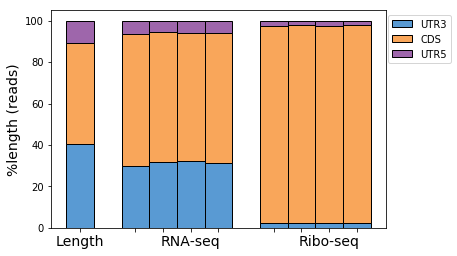

In [10]:
width = 1
groupgap = 1
human_colors = ['#599ad3', '#f9a65a', '#9e66ab']
human_ind = np.arange(1)
rna_ind = np.arange(len(rnas)) + groupgap + 1
ribo_ind = np.arange(len(ribos)) + 2*groupgap + len(rnas) + 1
ind = np.array([0, 2, 3, 4, 5, 7, 8, 9, 10])
fig, ax = plt.subplots()
human_utr3 = ax.bar(human_ind, human_proportions[2], width, color=human_colors[0], edgecolor='black', label="UTR3")
human_cds = ax.bar(human_ind, human_proportions[1], width, color=human_colors[1], edgecolor='black', bottom=human_proportions[2], label="CDS")
human_utr5 = ax.bar(human_ind, human_proportions[0], width, color=human_colors[2], edgecolor='black', bottom=human_proportions[1]+human_proportions[2], label="UTR5")

rna_utr5 = ax.bar(rna_ind, rna_proportions[2], width, color=human_colors[0], edgecolor='black')
rna_cds = ax.bar(rna_ind, rna_proportions[1], width, color=human_colors[1], edgecolor='black', bottom=rna_proportions[2])
rna_utr3 = ax.bar(rna_ind, rna_proportions[0], width, color=human_colors[2], edgecolor='black', bottom=rna_proportions[1]+rna_proportions[2])

ribo_utr5 = ax.bar(ribo_ind, ribo_proportions[2], width, color=human_colors[0], edgecolor='black')
ribo_cds = ax.bar(ribo_ind, ribo_proportions[1], width, color=human_colors[1], edgecolor='black', bottom=ribo_proportions[2])
ribo_utr3 = ax.bar(ribo_ind, ribo_proportions[0], width, color=human_colors[2], edgecolor='black', bottom=ribo_proportions[1]+ribo_proportions[2])

ax.set_ylabel('%length (reads)', fontsize=14)
ax.set_xticks(ind)
ax.set_xticklabels(('Length', '', '', 'RNA-seq', '', '', '', 'Ribo-seq'), fontsize=14)
plt.legend(loc=9, bbox_to_anchor=(1.1, 1.0))
plt.show()

pp = PdfPages('{}/{}_reads_proportions.pdf'.format(outputs, project))
pp.savefig(fig)
pp.close()

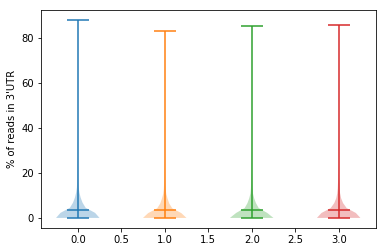

In [12]:
fig = plt.figure(1)
for i, ribo in enumerate(ribo_profiles):
    utr5 = ribo.utr5
    cds = ribo.cds
    utr3 = ribo.utr3
    data = pd.DataFrame({"utr3": utr3['length']*utr3['mean'], "total": (utr5['length']*utr5['mean'] + cds['length']*cds['mean'] + utr3['length']*utr3['mean'])})
    data = data.dropna(how='any')
    data = data[data['total'] > 100]
    data = data['utr3'] / data['total']
    plt.violinplot(np.array(data*100), [i], points=40, showmeans=True, showextrema=True, showmedians=False)
plt.ylabel('% of reads in 3\'UTR')
plt.show()
pp = PdfPages('{}/{}_genewise_reads_proportions.pdf'.format(outputs, project))
pp.savefig(fig)
pp.close()

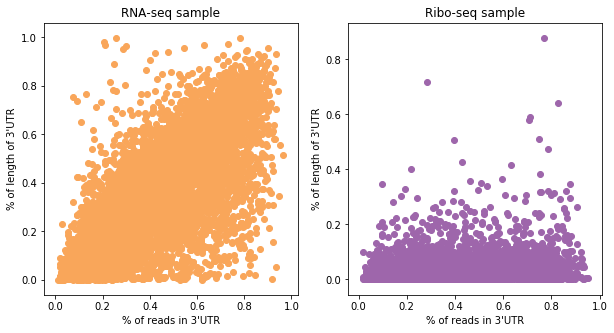

In [13]:
fig = plt.figure(1, figsize=(10, 5))
plt.subplot(121)
utr5 = rna_profiles[0].utr5
cds = rna_profiles[0].cds
utr3 = rna_profiles[0].utr3
data = pd.DataFrame({"utr3": utr3['length']*utr3['mean'], 
                     "total": (utr5['length']*utr5['mean'] + cds['length']*cds['mean'] + utr3['length']*utr3['mean']),
                     "human_utr3": human.utr3.seq.apply(len), 
                     "human_total": human.utr5.seq.apply(len) + human.cds.seq.apply(len) + human.utr3.seq.apply(len)})
data = data.dropna(how='any')
data = data[data['total'] > 100]
data_x = data['human_utr3'] / data['human_total']
data_y = data['utr3'] / data['total']
plt.scatter(np.array(data_x), np.array(data_y), color='#f9a65a')
plt.xlabel('% of reads in 3\'UTR')
plt.ylabel('% of length of 3\'UTR')
plt.title('RNA-seq sample')

plt.subplot(122)
utr5 = ribo_profiles[0].utr5
cds = ribo_profiles[0].cds
utr3 = ribo_profiles[0].utr3
data = pd.DataFrame({"utr3": utr3['length']*utr3['mean'], 
                     "total": (utr5['length']*utr5['mean'] + cds['length']*cds['mean'] + utr3['length']*utr3['mean']),
                     "human_utr3": human.utr3.seq.apply(len), 
                     "human_total": human.utr5.seq.apply(len) + human.cds.seq.apply(len) + human.utr3.seq.apply(len)})
data = data.dropna(how='any')
data = data[data['total'] > 100]
data_x = data['human_utr3'] / data['human_total']
data_y = data['utr3'] / data['total']
plt.scatter(np.array(data_x), np.array(data_y), color='#9e66ab')
plt.xlabel('% of reads in 3\'UTR')
plt.ylabel('% of length of 3\'UTR')
plt.title('Ribo-seq sample')

plt.show()

pp = PdfPages('{}/{}_corr_length_reads.pdf'.format(outputs, project))
pp.savefig(fig)
pp.close()

In [17]:
common_genes = set(human.utr3.index)
for ribo in ribo_profiles:
    ribo_series = pd.Series(ribo.utr3['mean']*ribo.utr3['length'])
    ribo_sorted = ribo_series.sort_values(ascending=False)
    top100 = ribo_sorted[:20].index
    common_genes = common_genes.intersection(set(top100))

In [18]:
len(common_genes)

18

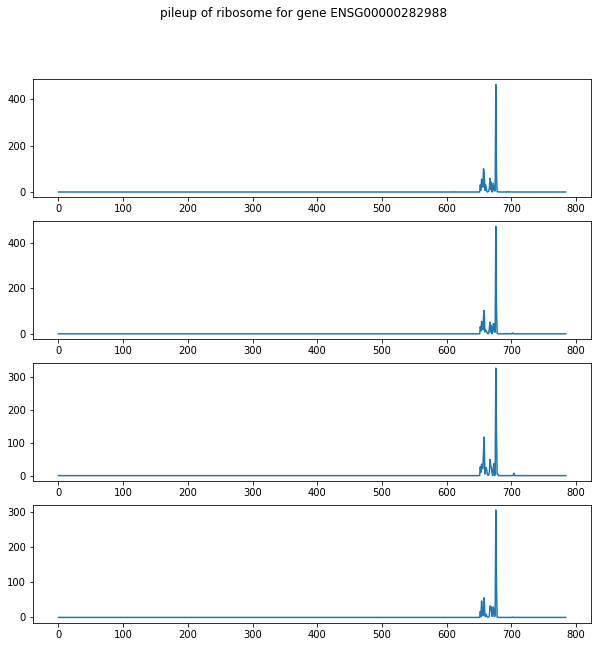

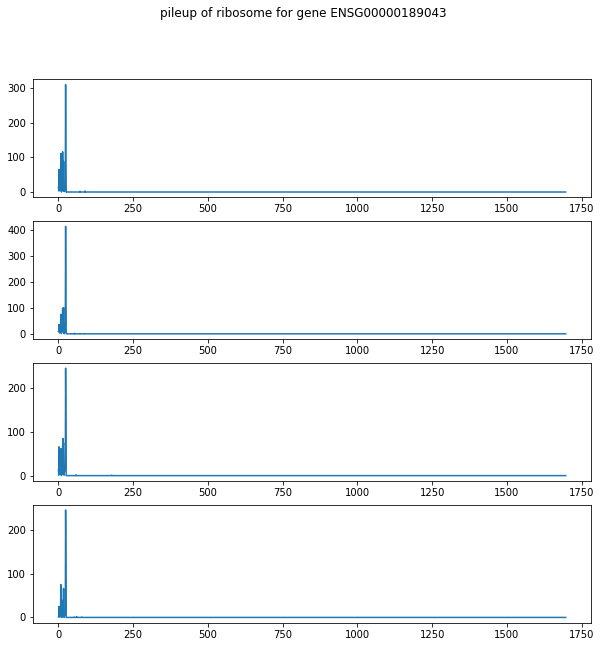

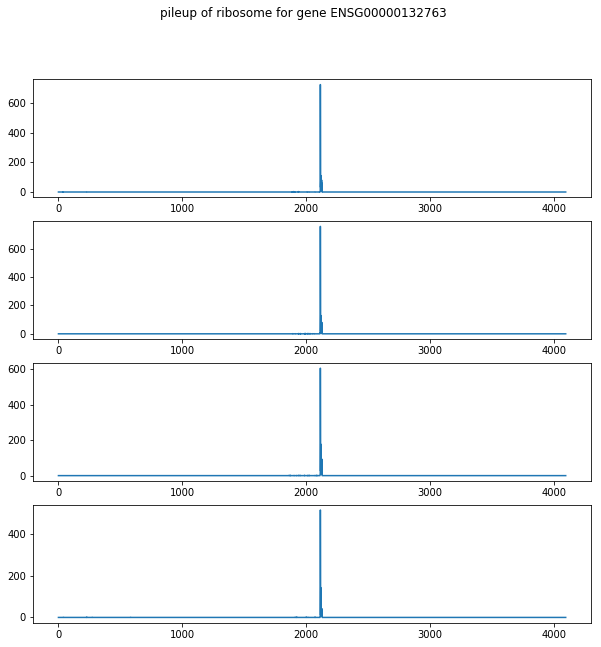

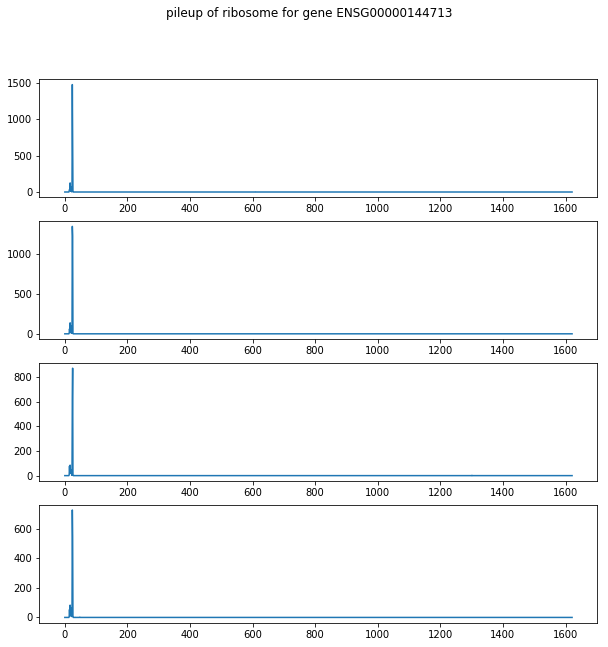

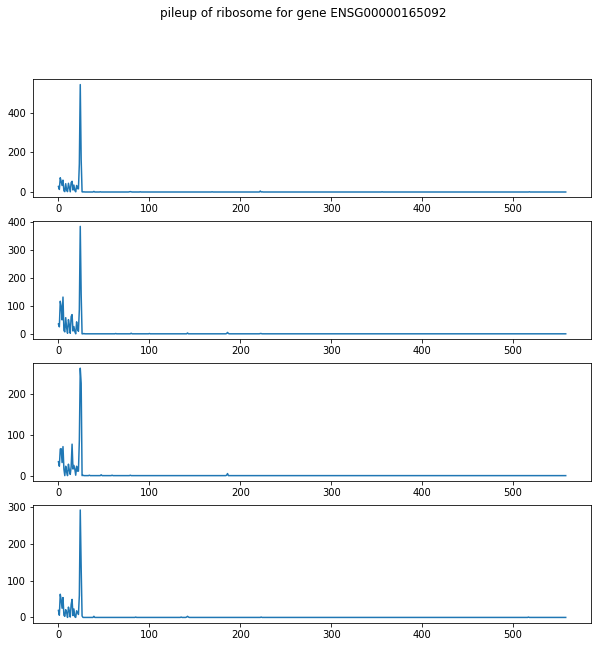

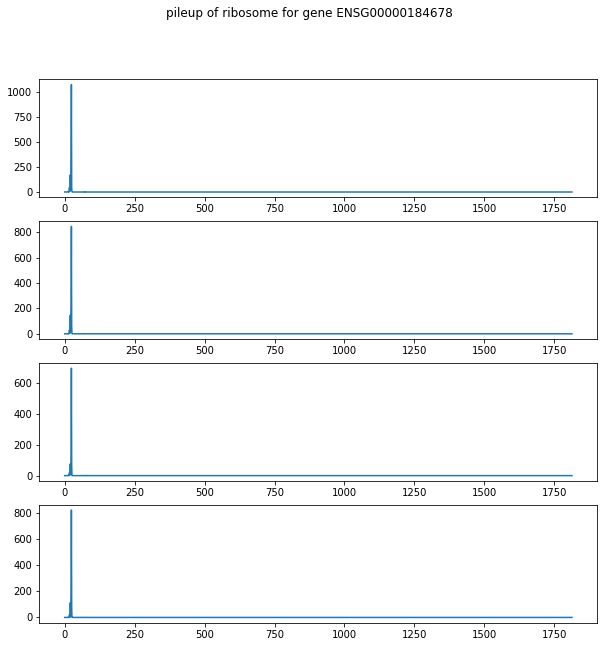

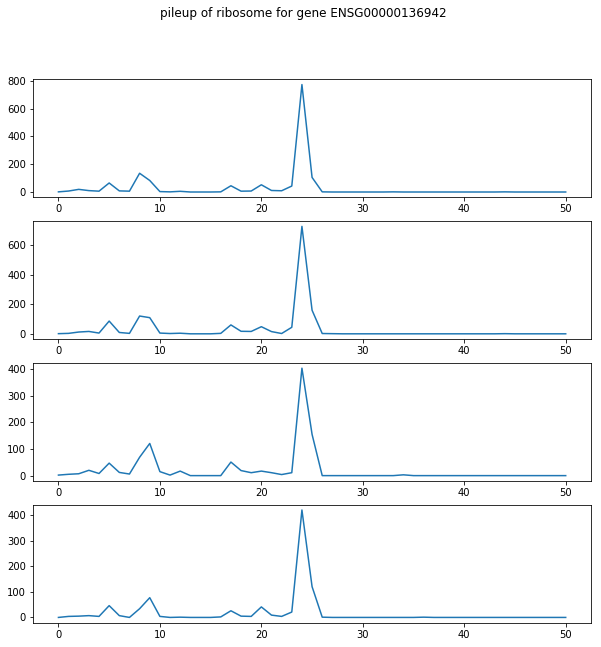

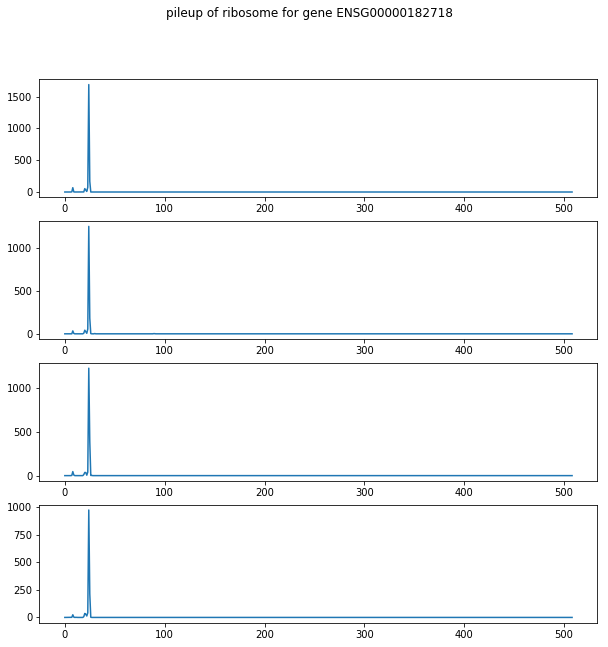

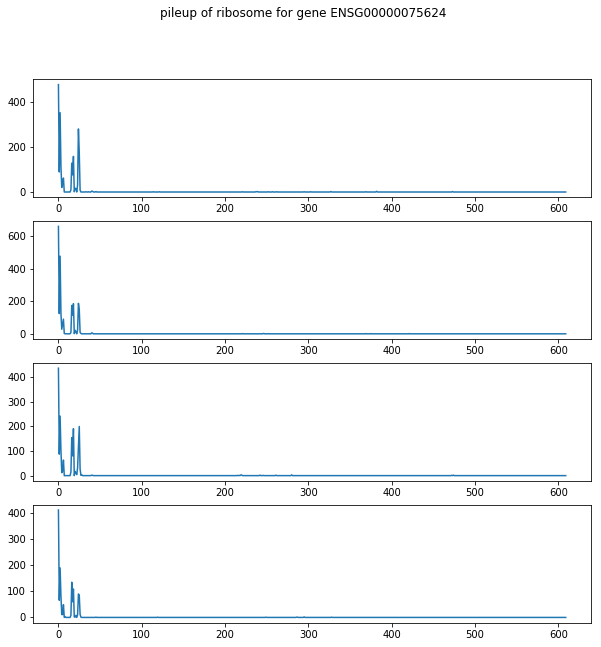

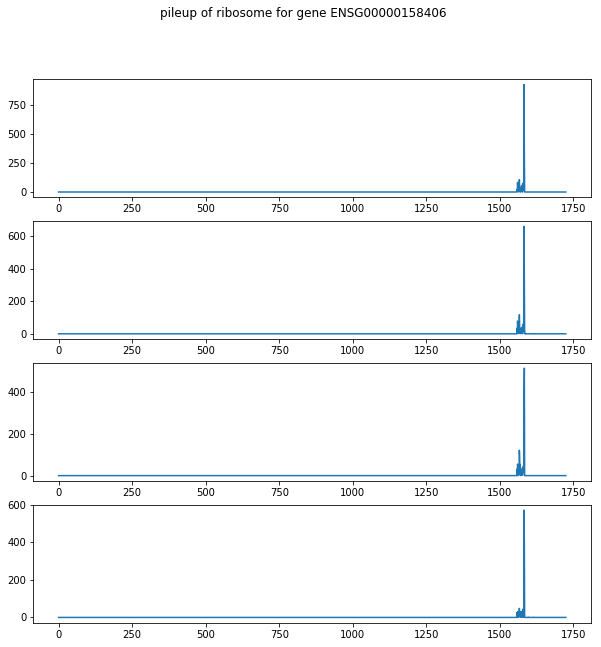

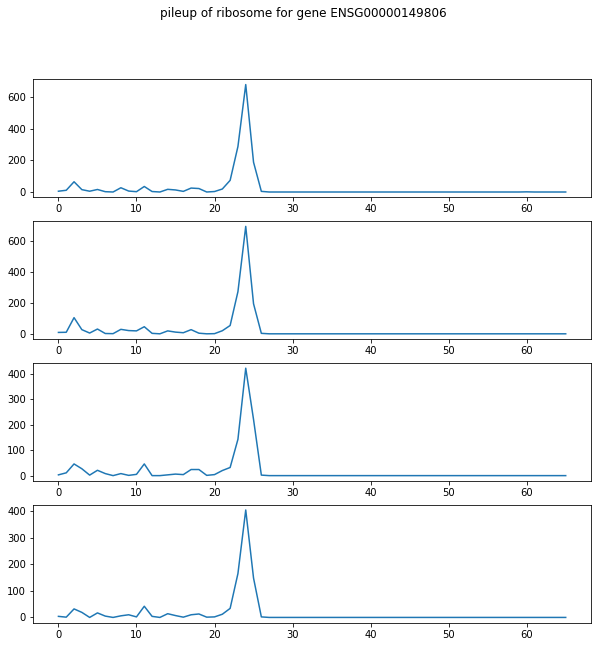

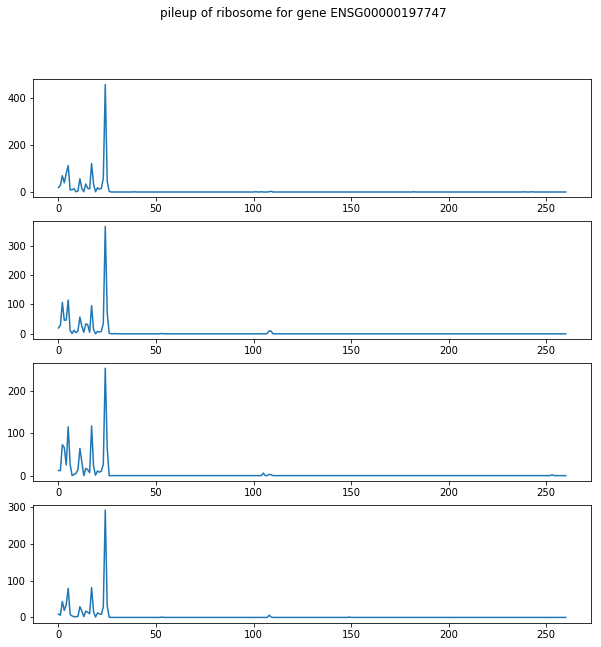

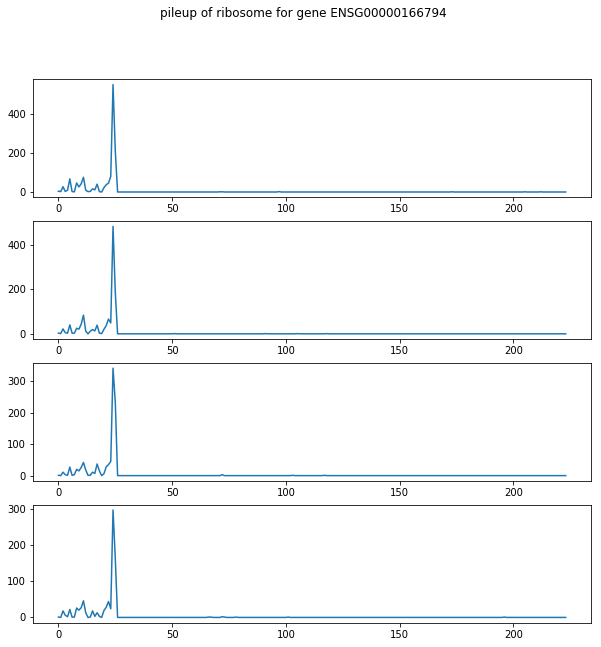

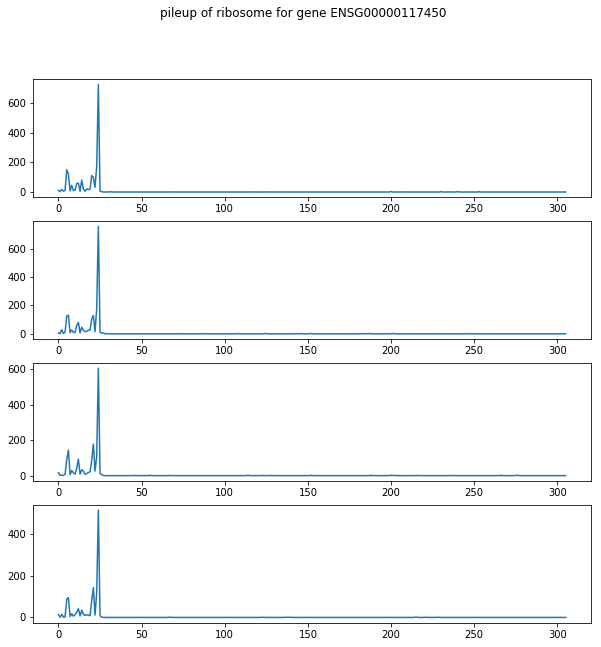

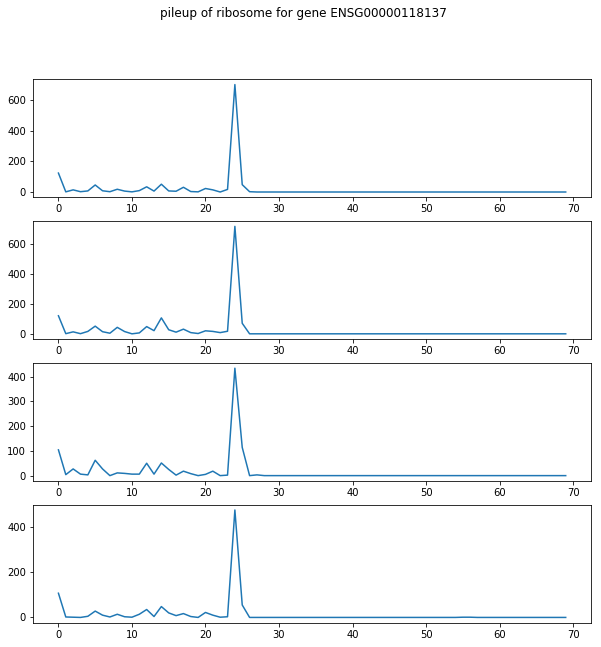

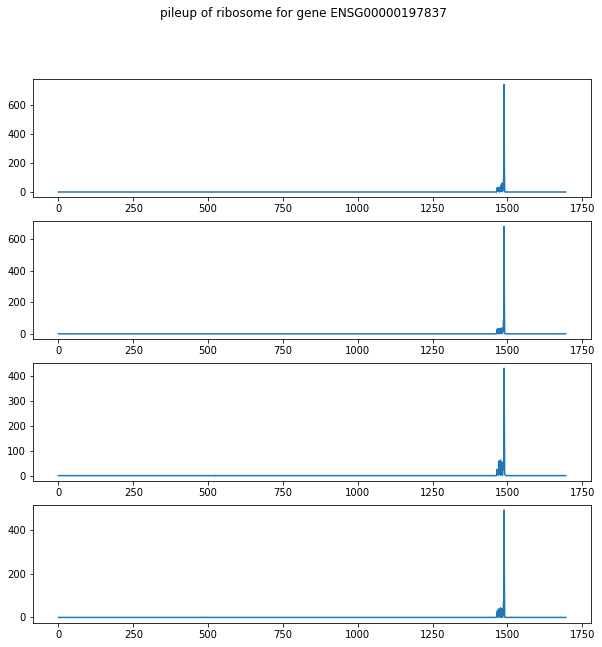

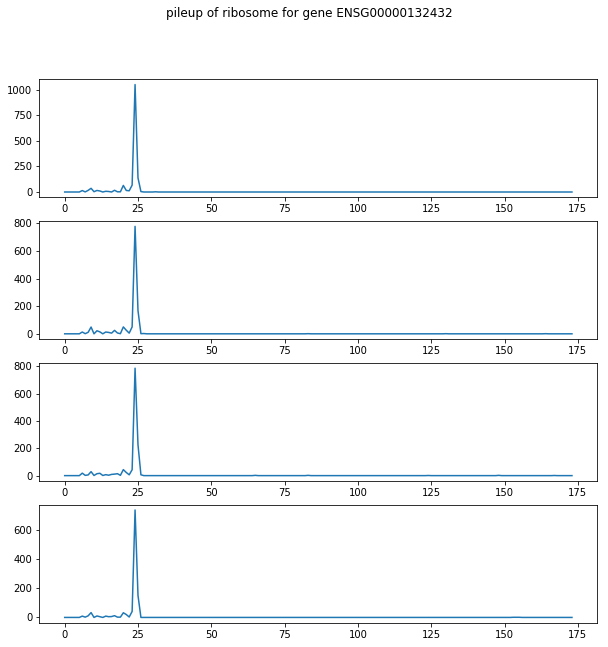

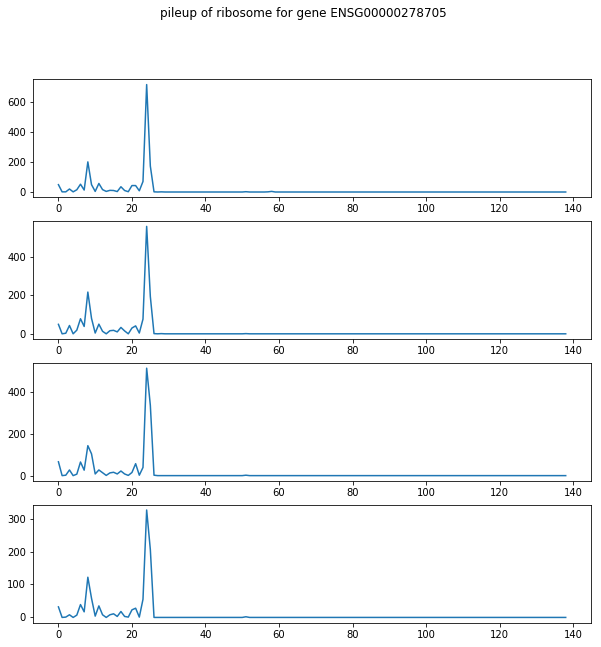

In [19]:
for i, gene in enumerate(common_genes):
    gene_name = gene
    fig = plt.figure(i+1, figsize=(10, 10))

    for i, ribo in enumerate(ribo_profiles):
        plt.subplot('{}1{}'.format(len(ribo_profiles), i))
        plt.plot(literal_eval(ribo.utr3.loc[gene]['count']))
    plt.suptitle("pileup of ribosome for gene {}".format(gene_name))
    plt.show()
    pp = PdfPages('{}/{}_{}_3utr.pdf'.format(outputs, project, gene_name))
    pp.savefig(fig)
    pp.close()

In [16]:
ribo_profiles[0].utr3.head()

,offset_5p,offset_3p,length,mean,median,stdev,count
gene_name,,,,,,,
ENSG00000000003,10,0,2920,0.019521,0.0,0.605310,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
ENSG00000000419,10,0,268,0.223881,0.0,1.775210,"[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 3.0, 0.0, ..."
ENSG00000000457,10,0,4085,0.013464,0.0,0.161283,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
ENSG00000000460,10,0,3718,0.075847,0.0,0.367673,"[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, ..."
ENSG00000001036,10,0,1309,0.032850,0.0,0.631239,"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 6.0, 4.0, ..."
